In [34]:
%load_ext autoreload
%autoreload 2

In [35]:
from collections import Counter


In [36]:
with open("data/training/text8_20m.txt") as f:
    text= f.read()
    
text[:100]

'anarchism originated as a term of abuse first used against early working class radicals including th'

**Text Preprocessing** 


In [37]:
words= text.split(" ")

words[:10]


['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

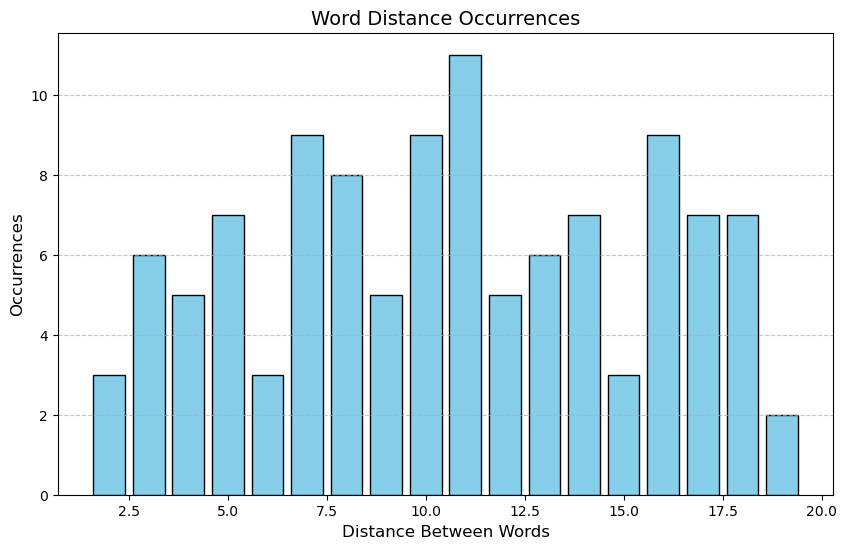

In [33]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

eval_words = [
    ["king", "queen", "prince", "princess", "aunt", "uncle", "daughter", "son"],
    ["paris", "france", "london", "england"],
    ["apple", "potato", "mango", "fruit"],
    ["lion", "wolf", "tiger", "elephant"],
    ["car", "truck", "vehicle", "bus"],
    ["neptune", "saturn", "pluto", "earth"]
]
t= eval_words[5]

distances= defaultdict(int)
last= 0

for i,w in enumerate(words):
    if w in t:
        d= i-last
        last= i
        distances[d]+=1


filtered_distances = {k: v for k, v in distances.items() if k<20}
sorted_filtered_distances = sorted(filtered_distances.items())
x, y = zip(*sorted_filtered_distances)



# Plot
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='skyblue', edgecolor='black')

plt.title("Word Distance Occurrences", fontsize=14)
plt.xticks()
plt.xlabel("Distance Between Words", fontsize=12)
plt.ylabel("Occurrences", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Building the Vocabulary**

In [38]:
words_count= Counter(words).most_common(60000)

most_freq_words= [item for item, _ in words_count]

#assigning unique id to every word
word_idx= {word: i+1 for i, word in enumerate(most_freq_words)}
word_idx['<UNK>']= 0

#converting text to idx
text_idx= [word_idx.get(w, word_idx['<UNK>']) for w in words]

#add freq of unfrequent words
words_count.append(('UNK', text_idx.count(0)))

text_idx[:10]

[1336, 2862, 13, 7, 194, 2, 4067, 49, 60, 137]

**Generate training data**

In [43]:
from random import shuffle
from alive_progress import alive_bar
def generate_training_pairs(words, C):
    training_pairs= []
    n= len(words)
    
    print('Generating training data...')

    with alive_bar(n, force_tty= True) as bar:
        for i, center_word in enumerate(words):
            start_idx= max(0, i-C)
            end_idx= min(n-1, i+C+1)
            
            for j in range(start_idx, end_idx):
                if j!=i: #skip center word
                    training_pairs.append((center_word, words[j]))
            bar()
        
        shuffle(training_pairs)
        return training_pairs

C= 2

data= generate_training_pairs(text_idx, C)


Generating training data...
|████████████████████████████████████████| 2000000/2000000 [100%] in 6.3s (32347


Calculate unigram and smoothed unigram distribution

In [39]:
import numpy as np
N= sum([c for _,c in words_count])
alpha= 3/4

unigram= {word: freq/N for word,freq in words_count}

unigram_sum= sum(u**alpha for u in unigram.values())

smoothed_unigram= {word: (uni**alpha)/unigram_sum for word, uni in unigram.items()}

unigram_table= np.array(list(smoothed_unigram.values()))


**Training Loop**

In [40]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from Skipgram import Skipgram
from NegativeSamplingLoss import NegativeSamplingLoss
import torch
import numpy as np
from alive_progress import alive_bar

def train_skipgram(train_dataset, validation_dataset, vocab_size, unigram, embedding_dim,
                   batch_size=64, epochs=5, learning_rate=0.01, num_negatives=20):
    
    train_dataloader= DataLoader(train_dataset, batch_size)
    
    model= Skipgram(vocab_size, embedding_dim)
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    model= model.to(device)
    
    criterion= NegativeSamplingLoss()
    optim= Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    
    for epoch in range(epochs):
        total_train_loss= 0
                
        with(alive_bar(len(train_dataloader), force_tty=True)) as bar:
            for i,(center, contexts) in enumerate(train_dataloader):
                center, contexts = center.long().to(device), contexts.long().to(device)
                
                #make sure batch_size is equal
                current_batch_size= len(center)
                
                #sample negatives from unigram
                negatives= torch.tensor(
                    np.random.choice(
                        vocab_size, (current_batch_size, num_negatives), p= unigram),
                    dtype=torch.long,
                    device=device
                )
                
                #forward pass
                positive_score, negative_score= model(center, contexts, negatives)
                
                loss= criterion(positive_score, negative_score)
                
                #backward pass
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                total_train_loss+= loss.item()
                bar()
                
            train_loss= total_train_loss/len(train_dataloader)
                
            #validation   
            val_dataloader= DataLoader(validation_dataset, batch_size=batch_size)     
            model.eval()  
            total_val_loss = 0
            
            with torch.no_grad(): 
                for center, contexts in val_dataloader:
                    center, contexts = center.long().to(device), contexts.long().to(device)
                    
                    current_batch_size = len(center)
                    
                    #sample negatives from unigram
                    negatives = torch.tensor(
                        np.random.choice(vocab_size, (current_batch_size, num_negatives), p=unigram),
                        dtype=torch.long, device=device)
                    
                    # Forward pass
                    positive_score, negative_score = model(center, contexts, negatives)
                    
                    # Calculate validation loss
                    loss = criterion(positive_score, negative_score)
                    
                    total_val_loss += loss.item()
            val_loss = total_val_loss / len(val_dataloader)
               
          
        print(f"Epoch {epoch+1}/{epochs} -- Train Loss: {train_loss:.4F} -- Validation Loss: {val_loss:.4F}")

    return model, train_loss, val_loss
            

In [41]:
import json

def log_results(results, log_file, best_result):
        current_best = min(results, key=lambda x: x['val_loss'])
        print("Best Hyperparameters:")
        print(current_best)

        #log results
        with open(log_file, "r") as f:
            result_log= json.load(f)
            
            for r in results:
                result_log.append(r)
        
        with(open(log_file, "w")) as f:
            json.dump(result_log, f, indent=4)
        
        
        with open(best_result, "r") as f:
            previous_best = json.load(f)
        
        # Compare validation losses
        if current_best['val_loss'] < previous_best['val_loss']:
            print("New best result found. Overwriting 'best_result.json'...")
            with open(best_result, "w") as f:
                json.dump(current_best, f, indent=4)
        else:
            print("Previous best result retained.")
        print("Progress saved to 'log/' folder. Exiting...")

**Training**

In [45]:
import itertools
import random
from SkipgramDataset import SkipgramDataset
import time
from torch.utils.data import random_split
import json
import os

torch.manual_seed(42)

### Hyperparameter Grid ###
context_sizes = [4, 6]
embedding_dims = [ 300, 400, 500]
batch_sizes = [256, 512]
learning_rates = [0.01, 0.001]
num_negatives_list = [10, 15, 20]
epochs_list = [5]
##########################

# Hyperparameter combinations
hyperparameter_combinations = list(itertools.product(context_sizes,embedding_dims, batch_sizes, learning_rates, num_negatives_list, epochs_list))

VOCAB_SIZE = 60001
BEST_RESULT= 'log/best_result.json'
COMBINATIONS_LOG= 'log/combinations_log.json'
RESULTS_LOG= 'log/results_log.json'
num_combinations= 10

results = []

# Randomly sample combinations
sampled_combinations = random.sample(hyperparameter_combinations, num_combinations)

#for comparison 
with open(COMBINATIONS_LOG, "r") as f:
         tested_combinations = set(tuple(c) for c in json.load(f)) 
        
#for logging 
with open(COMBINATIONS_LOG, "r") as f:
         combination_log = json.load(f)
         
#filter evaluated combinations
remaining_combinations = [
    comb for comb in hyperparameter_combinations if comb not in tested_combinations
]

num_combinations = len(sampled_combinations)
print(f"Total combinations sampled: {num_combinations}")

t0 = time.time()
try:
    for i, (context_size, embedding_dim, batch_size, learning_rate, num_negatives, epochs) in enumerate(sampled_combinations):
        print(f"Running combination {i+1}/{num_combinations}: ")
        print(f"Context Size: {context_size}, Embedding Dim: {embedding_dim}, Batch Size: {batch_size}, Learning Rate: {learning_rate}, Num Negatives: {num_negatives}, Epochs: {epochs}")

        #generate data
        data = generate_training_pairs(text_idx, context_size)

        dataset = SkipgramDataset(data[:1000000])
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        #train model
        model, train_loss, val_loss = train_skipgram(
            train_dataset, val_dataset, VOCAB_SIZE, unigram_table,
            embedding_dim=embedding_dim,
            batch_size=batch_size,
            epochs=epochs,
            learning_rate=learning_rate,
            num_negatives=num_negatives
        )
        
        #save tested combinations
        combination_log.append(list(sampled_combinations[i]))
        with open(COMBINATIONS_LOG, 'w') as f:
            json.dump(combination_log, f, indent=4)

        results.append({
            "context_size": context_size,
            "embedding_dim": embedding_dim,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_negatives": num_negatives,
            "epochs": epochs,
            "train_loss": train_loss,
            "val_loss": val_loss
        })
        
            
        print(f"Train Loss: {train_loss}, Val Loss: {val_loss}\n")
        
    log_results(results, RESULTS_LOG, BEST_RESULT)

except KeyboardInterrupt:
    print("\nKeyboardInterrupt detected. Saving progress...")

    if len(results) > 0:
        log_results(results, RESULTS_LOG, BEST_RESULT)      
    else:
        print("No results to analyze.")
        

t1 = time.time()


print(f"Total Time: {t1-t0:.2F} seconds")





Total combinations sampled: 10
Running combination 1/10: 
Context Size: 6, Embedding Dim: 300, Batch Size: 256, Learning Rate: 0.01, Num Negatives: 10, Epochs: 5
Generating training data...
|████████████████████████████████████████| 2000000/2000000 [100%] in 33.4s (6022 ▆▄▂ 2000000/2000000 [100%] in 15s (~0
|████████████████████████████████████████| 3516/3516 [100%] in 5:13.8 (11.21/s) 
Epoch 1/5 -- Train Loss: 4.6089 -- Validation Loss: 3.6003
|████████████████████████████████████████| 3516/3516 [100%] in 5:13.9 (11.21/s) 
Epoch 2/5 -- Train Loss: 3.5467 -- Validation Loss: 3.5174
|████████████████████████████████████████| 3516/3516 [100%] in 5:18.0 (11.07/s) 
Epoch 3/5 -- Train Loss: 3.4785 -- Validation Loss: 3.4718
|████████████████████████████████████████| 3516/3516 [100%] in 5:11.4 (11.30/s) 
Epoch 4/5 -- Train Loss: 3.4470 -- Validation Loss: 3.4534
|████████████████████████████████████████| 3516/3516 [100%] in 5:15.2 (11.16/s) 
Epoch 5/5 -- Train Loss: 3.4344 -- Validation Loss

IOStream.flush timed out


|████████████████████████████████████████| 3516/3516 [100%] in 6:22.5 (9.20/s)  
Epoch 3/5 -- Train Loss: 4.3418 -- Validation Loss: 4.3041
|████████████████████████████████████████| 3516/3516 [100%] in 6:36.3 (8.88/s)   ▅▃▁ 1033/3516 [29%] in 1:43 (~4:00, 1 ▇▅▃ 1138/3516 [32%] in 1:55 (~4:00, 9
Epoch 4/5 -- Train Loss: 4.2690 -- Validation Loss: 4.2696
|████████████████████████████████████████| 3516/3516 [100%] in 7:26.4 (7.88/s)   ▂▄▆ 524/3516 [15%] in 46s (~4:20, 11. ▇▇▅ 542/3516 [15%] in 50s (~4:30, 10. ▂▄▆ 2520/3516 [72%] in 5:27 (~2:10, 7 ▇▅▃ 2544/3516 [72%] in 5:29 (~2:00, 7 ▇▅▃ 3184/3516 [91%] in 6:42 (~42s, 7. ▇▇▅ 3226/3516 [92%] in 6:46 (~37s, 7. ▂▄▆ 3323/3516 [95%] in 7:07 (~25s, 7.
Epoch 5/5 -- Train Loss: 4.2340 -- Validation Loss: 4.2553
Train Loss: 4.234005109577591, Val Loss: 4.255284277679365

Running combination 10/10: 
Context Size: 6, Embedding Dim: 500, Batch Size: 512, Learning Rate: 0.01, Num Negatives: 20, Epochs: 5
Generating training data...
|█████████████████

In [ ]:
from SkipgramDataset import SkipgramDataset
import time
from torch.utils.data import random_split

torch.manual_seed(42)

### Hyperparameters ###
EMBEDDING_DIM= 400
BATCH_SIZE= 512
EPOCHS= 5
LEARNING_RATE= 0.001
NUM_NEGATIVES= 10
#######################

dataset= SkipgramDataset(data[:1000000])

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

vocab_size= 60001

t0= time.time()
model,_,_ = train_skipgram(train_dataset, val_dataset, vocab_size, unigram_table,
                       embedding_dim= EMBEDDING_DIM,
                       batch_size= BATCH_SIZE,
                       epochs= EPOCHS,
                       learning_rate=LEARNING_RATE,
                       num_negatives=NUM_NEGATIVES)
t1= time.time()

print(f"Time: {t1-t0:.2F} seconds")


|████████████████████████████████████████| 1758/1758 [100%] in 3:48.5 (7.70/s)  
Epoch 1/5 -- Train Loss: 18.3135 -- Validation Loss: 12.1883
|████████████████████████████████████████| 1758/1758 [100%] in 3:59.4 (7.35/s)  
Epoch 2/5 -- Train Loss: 9.0550 -- Validation Loss: 6.8440
|████████████████████████████████████████| 1758/1758 [100%] in 3:47.8 (7.72/s)  
Epoch 3/5 -- Train Loss: 5.3262 -- Validation Loss: 4.7469
|████████████████████████████████████████| 1758/1758 [100%] in 3:54.8 (7.49/s)  
Epoch 4/5 -- Train Loss: 3.8096 -- Validation Loss: 3.9459
|████████████████████████████████████████| 1758/1758 [100%] in 3:57.9 (7.40/s)  
Epoch 5/5 -- Train Loss: 3.1953 -- Validation Loss: 3.6111
Time: 1170.84 seconds


In [ ]:
torch.save(model.state_dict(), 'model.pth')


In [ ]:
import torch

torch.cuda.empty_cache()

**Evaluation**

Calculate word embeddings for the evaluation words.

In [ ]:
import pandas as pd

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# model = Skipgram(vocab_size, embedding_dim) 
# model.to(device)
# model.load_state_dict(torch.load('model.pth'))

model.eval()

wordsim353_df = pd.read_csv("data/evaluation/wordsim353.csv")

def get_embedding(word, model, word_idx, device):
    if word in word_idx:
        embedding = model.center_embedding(torch.tensor(word_idx[word]).to(device)).detach().cpu().numpy()
        return embedding / np.linalg.norm(embedding)  # Normalize the vector
    return None

# Compute embeddings for both words in the pair
wordsim353_df['W1 Embedding'] = wordsim353_df['Word 1'].apply(lambda w: get_embedding(w, model, word_idx, device))
wordsim353_df['W2 Embedding'] = wordsim353_df['Word 2'].apply(lambda w: get_embedding(w, model, word_idx, device))

def compute_cosine_similarity(v1, v2):
    if v1 is not None and v2 is not None:
        return np.dot(v1, v2)  
    return None

wordsim353_df['Cosine Similarity'] = wordsim353_df.apply(
    lambda row: compute_cosine_similarity(row['W1 Embedding'], row['W2 Embedding']),
    axis=1
)

#drop rows with words which are not in vocabulary
wordsim353_df=wordsim353_df.dropna(axis=0)

wordsim353_df.head()

,Word 1,Word 2,Human (mean),W1 Embedding,W2 Embedding,Cosine Similarity
0,love,sex,6.77,"[-0.019403948, -8.680266e-06, 0.0049172505, -0...","[0.0070173377, 0.0067685363, 0.010561045, -0.0...",0.893414
1,tiger,cat,7.35,"[-0.013211561, 0.02752974, 0.0021560914, -0.03...","[-0.0070146257, 0.023178576, -0.002903437, -0....",0.931484
2,tiger,tiger,10.00,"[-0.013211561, 0.02752974, 0.0021560914, -0.03...","[-0.013211561, 0.02752974, 0.0021560914, -0.03...",1.000000
3,book,paper,7.46,"[0.0056962566, 0.0019751287, 0.0010741596, 0.0...","[0.0021809018, 0.008476213, 0.0030994355, -0.0...",0.893701
4,computer,keyboard,7.62,"[-0.01278451, -0.00527275, -0.011605624, -0.02...","[-0.008757365, 0.015188951, -0.0016136339, -0....",0.824069


Compare inferred cosine similarity and human-assigned similarity using Spearman’s rank correlation coefficient.

In [ ]:
from scipy.stats import spearmanr

cosine_sim= np.array(wordsim353_df['Cosine Similarity'])
human_score= np.array(wordsim353_df['Human (mean)'])

spearman_coef= spearmanr(cosine_sim, wordsim353_df['Human (mean)'])

spearman_coef

SignificanceResult(statistic=0.21650301118332502, pvalue=8.760813857874812e-05)

**Visualization**

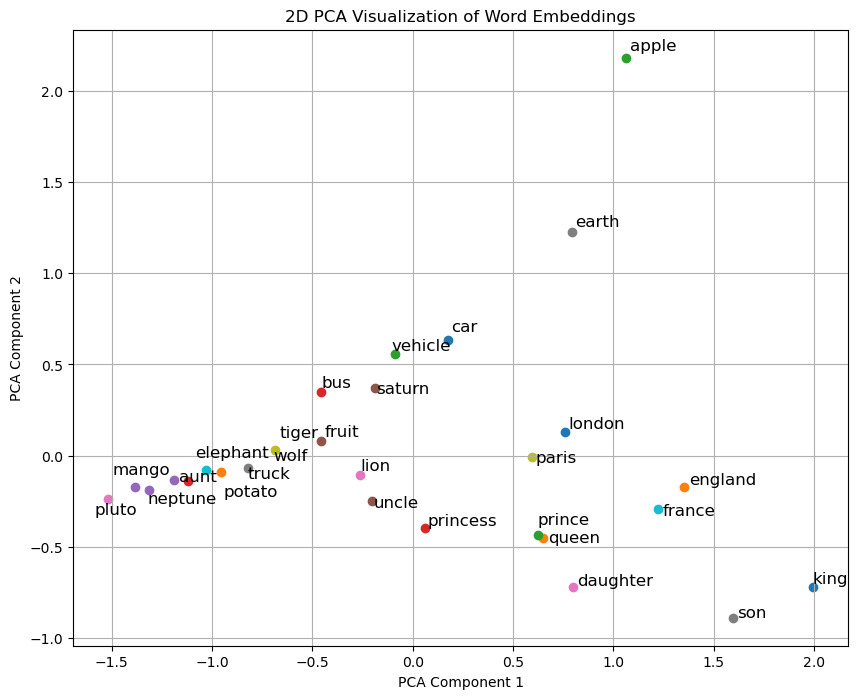

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from adjustText import adjust_text
from sklearn.manifold import TSNE

def visualize_reduced_embeddings(reduced_embeddings, labels):

    plt.figure(figsize=(10, 8))
    
    texts = []  # List to store text objects for adjustment
    for i, word in enumerate(labels):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y)
        text = plt.text(x + 0.01*x, y + 0.01*y, word, fontsize=12)  # Create a text object
        texts.append(text)  # Append the text object to the list

    adjust_text(texts)

    plt.title('2D PCA Visualization of Word Embeddings')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()


eval_words = [
    "king", "queen", "prince", "princess", "aunt", "uncle", "daughter", "son",
    "paris", "france", "london", "england",
    "apple", "potato", "mango", "fruit",
    "lion", "wolf", "tiger", "elephant",
    "car", "truck", "vehicle", "bus",
    "neptune", "saturn", "pluto", "earth"
]

eval_words_embeddings= [model.center_embedding(torch.tensor(word_idx.get(w)).to(device)).cpu().detach().numpy()
                                 for w in eval_words] 


pca= PCA(n_components=2)

reduced_embeddings= pca.fit_transform(np.array(eval_words_embeddings)) 
visualize_reduced_embeddings(reduced_embeddings, eval_words)